In [202]:
import polars as pl
import geopandas as gpd
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from datetime import datetime
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [154]:
monthly_cases = pl.read_parquet('../data/cases/agged/dengue_per_month.parquet')
monthly_params = pl.read_parquet('../data/gee_exports/all_parameters_2001-01-01_2021-01-01_months.parquet')
weekly_cases = pl.read_parquet('../data/cases/agged/dengue_per_week.parquet')

In [4]:
munis = gpd.read_file('../data/brazil/munis/munis_simple.shp')

In [187]:
monthly_params = monthly_params.with_columns((pl.col('start_date').str.to_date('%Y-%m-%d'),pl.col('end_date').str.to_date('%Y-%m-%d')))

In [185]:
#monthly_params.sort(['muni_id', 'end_date'])
monthly_cases = monthly_cases.with_columns(pl.col('ID_MUNICIP').str.slice(offset=0,length=6).cast(pl.Int64)).sort('DT_NOTIFIC').rename({
    'DT_NOTIFIC': 'start_date',
    'ID_MUNICIP': 'muni_id'
})

In [156]:
weekly_cases = weekly_cases.with_columns(pl.col('ID_MUNICIP').str.slice(offset=0,length=6).cast(pl.Int64)).sort('DT_NOTIFIC').rename({
    'DT_NOTIFIC': 'start_date',
    'ID_MUNICIP': 'muni_id'
}).with_columns(pl.col('start_date').alias('month').dt.month())

In [188]:
all_data = monthly_cases.join(monthly_params, how='left', on=['muni_id', 'start_date']).with_columns(pl.col('end_date').alias('month').dt.month())


In [11]:
test_muni = all_data.filter(pl.col('muni_id') == 530010)

In [189]:
cluster_features = ['cases_per_100k', 
                     #'temperature_2m', 
                     #'total_precipitation_min', 
                    # 'EVI'
                    ]
case_matrix = np.vstack(
                all_data
                #weekly_cases
               .select(pl.col(['end_date', 'muni_id',  'month'] + cluster_features))
               .filter(
                    (pl.col('end_date') >= datetime(2010,1,1)) &
                    (pl.col('end_date') < datetime(2019,1,1)) &
                    (pl.col('month').is_in([11, 12, 1, 2, 3, 4, 5]))
                    )
               .sort('end_date')
               .group_by('muni_id', maintain_order=True)
               .agg([pl.col(f) for f in cluster_features])
               .sort('muni_id')
               .select(pl.concat_list(cluster_features))
               .to_series()
               )
case_matrix.shape

(5570, 63)

In [222]:
X = case_matrix
nbrs = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [191]:
index_muni_mapper = {m:i for m, i in enumerate(all_data.select('muni_id').unique().sort('muni_id').to_series())}

In [223]:
connections = pl.DataFrame({
    'muni_id': all_data.select('muni_id').unique().sort('muni_id').to_series(),
    'indices': indices,
    'distances': distances
}).with_columns(pl.col('indices').list.eval(pl.element().map_dict(index_muni_mapper)).alias('muni_neighbors'))

In [193]:
def select_muni_and_neighbors(muni_id, data_df, connections_df) -> pl.DataFrame: 
    return (
        data_df
        .filter(
            pl.col('muni_id')
            .is_in(connections_df
                   .filter(pl.col('muni_id') == muni_id)
                   .select('muni_neighbors')
                   .to_series()
                   .item()
                )
            )
    )

    

In [194]:
def get_solo_training_target(df, muni_id, month_lag, predict_lag):
    lagged_df = (df
        .filter(pl.col('muni_id') == muni_id)
        .sort('end_date')
        .with_columns(
            case_lag = pl.col('cases_per_100k')
            .rolling(index_column='end_date', period=f'{month_lag}mo')
            .list
            .head(month_lag - predict_lag)
            )
        .filter(pl.col('case_lag').list.len() == month_lag-predict_lag)
        .select(['cases_per_100k', 'case_lag'])
    )
    target = lagged_df.select('cases_per_100k').to_series().to_numpy()
    train = np.vstack(lagged_df.select('case_lag').to_series())

    return train, target

In [224]:
neighbor_list = (connections.filter(pl.col('muni_id') == 230835)
                   .select('muni_neighbors')
                   .to_series()
                   .item()
)
train_list = []
first_train, target = get_solo_training_target(all_data, neighbor_list[0], 24, 1)
train_list.append(first_train)
for neighbor in neighbor_list[1:]:
    to_add, _ = get_solo_training_target(all_data, neighbor, 23, 0)
    train_list.append(to_add)
X = np.concatenate(train_list, axis=1)
y = target

In [225]:
X.shape

(218, 345)

In [114]:
#X, y = get_solo_training_target(all_data, 230835, 24, 1)


In [226]:
reg = HistGradientBoostingRegressor()

In [227]:
t =reg.fit(X[:200,:], y[:200])

In [228]:
z = t.predict(X[200:,:])
z

array([ 341.08003208,  322.39124239,  477.18828014,  535.06229392,
        190.42985693,   26.99041801,   66.50829731,   68.47464939,
        -79.3081308 ,  -73.39353289, -144.05005335,   41.60398129,
        146.78734256,  204.99901252,   58.47316131,  177.94853809,
        200.61969553,  -33.73410489])

In [229]:
t.score(X[200:,:],y[200:])

-13.997729193993642

In [230]:
mean_squared_error(y[200:], z)**1/2

18163.25655318578

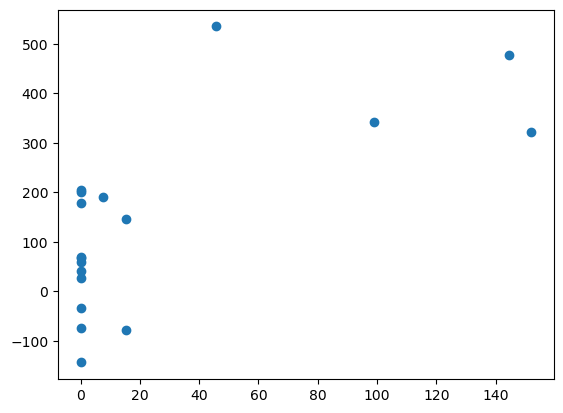

In [231]:
plt.scatter(y[200:], z)